In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata
import os

import TileUtility as TU

%matplotlib notebook

In [2]:
HT = TU.HalfTiles(TU.FullTiles())

In [3]:
# based on code from MP1 utils.py
def prompt_eye_selection(image):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    fig.set_label('Click on corners of game board')
    plt.axis('off')
    xs = []
    ys = []
    clicked = np.zeros((4, 2), dtype=np.float32)

    # Define a callback function that will update the textarea
    def onmousedown(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)

        plt.plot(xs, ys, 'r-+')

    def onmouseup(event):
        if(len(xs) >= 4):
            plt.plot(xs ++ xs[0], ys ++ ys[0], 'r-+')
            plt.close(fig)

    def onclose(event):
        clicked[:, 0] = xs
        clicked[:, 1] = ys
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [4]:
# Zoom in where user clicked and let them adjust it.
def fineTunePoint(image, point):
    fig = plt.figure()
    
    Z = np.array([[point[0] - 50, point[1] - 50], [point[0] + 50, point[1] + 50]]).astype(int)
    plt.imshow(image[Z[0,1]:Z[1,1], Z[0,0]:Z[1,0]])
    plt.plot(50, 50, 'y-+')
    
    fig.set_label('Fine Tune Corner Selection')
    plt.axis('off')
    clicked = point
    hasClicked = False
    x = []
    y = []
    
    # Define a callback function that will update the textarea
    def onmousedown(event):
        x.append(event.xdata)
        y.append(event.ydata)
        hasClicked = True
        clicked[0] = x[0] + point[0] - 50
        clicked[1] = y[0] + point[1] - 50
        print("clicked is now {0}".format(clicked))
        plt.plot(x, y, 'r-+')

    def onmouseup(event):
        plt.plot(x, y, 'r-+')

    def onclose(event):
        pass
    
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [179]:
# My implementation of 4pt homography
#  This maps 4 points from origin onto a square 5*tile_res
# Getting this code to work was easy
# ..getting it to work fast was hard.

def fourPointExplodingHeartHomography(image, origin, tile_res):
    R = tile_res*5
    cx = [ p[0] for p in origin ]
    cy = [ p[1] for p in origin ]
    ix = [ 0, R, R, 0 ]
    iy = [ 0, 0, R, R ]

    # This setup follows 
    # http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf
    T1 = np.array([
        [cx[0], cy[0], 1.,     0,     0,  0, -cx[0]*ix[0], -cy[0]*ix[0]],
        [    0,     0,  0, cx[0], cy[0],  1, -cx[0]*iy[0], -cy[0]*iy[0]],
        [cx[1], cy[1], 1.,     0,     0,  0, -cx[1]*ix[1], -cy[1]*ix[1]],
        [    0,     0,  0, cx[1], cy[1],  1, -cx[1]*iy[1], -cy[1]*iy[1]],
        [cx[2], cy[2], 1.,     0,     0,  0, -cx[2]*ix[2], -cy[2]*ix[2]],
        [    0,     0,  0, cx[2], cy[2],  1, -cx[2]*iy[2], -cy[2]*iy[2]],
        [cx[3], cy[3], 1.,     0,     0,  0, -cx[3]*ix[3], -cy[3]*ix[3]],
        [    0,     0,  0, cx[3], cy[3],  1, -cx[3]*iy[3], -cy[3]*iy[3]]])

    c1 = np.array([ix[0], iy[0], ix[1], iy[1], ix[2], iy[2], ix[3], iy[3]])
    est = np.linalg.solve(T1, c1)
    A = np.array([
        [est[0], est[1], est[2]],
        [est[3], est[4], est[5]],
        [est[6], est[7], 1.0]])
    Ainv = np.linalg.inv(A)

    # Maps origin onto target
    def regMap(xs, ys):
        txs = A[0, 0]*xs + A[0, 1]*ys + A[0, 2]
        tys = A[1, 0]*xs + A[1, 1]*ys + A[1, 2]
        hs = A[2, 0]*xs + A[2, 1]*ys + A[2, 2]
        txs = txs / hs
        tys = tys / hs
        return txs, tys

    # Maps target onto origin
    def invMap(xs, ys):
        txs = Ainv[0, 0]*xs + Ainv[0, 1]*ys + Ainv[0, 2]
        tys = Ainv[1, 0]*xs + Ainv[1, 1]*ys + Ainv[1, 2]
        hs = Ainv[2, 0]*xs + Ainv[2, 1]*ys + Ainv[2, 2]
        txs = txs / hs
        tys = tys / hs
        return txs, tys

    # The next few lines take pixel locations in the origin image within the boundaries
    #  and map them onto their target pixel.  It is expected that for a high resolution image
    #  this will happen a few dozen times for each target pixel.  Thus we just sum up the pixels
    #  landing here and divide by the number of hits later.
    old_grid_y, old_grid_x = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    target_xs, target_ys = regMap(old_grid_x, old_grid_y)
    txs = target_xs.astype('int32')
    tys = target_ys.astype('int32')

    sumpixel = np.zeros((R,R,3), 'int64')
    counts = np.zeros((R,R,3), 'int32')

    # The mask will be true when a given pixel location is in bounds
    mask = np.logical_and(np.logical_and(tys >= 0, tys < R),
                          np.logical_and(txs >= 0, txs < R))
    
    # This is a bit esoteric function I guess, but found this helpful comment on stackoverflow
    # https://stackoverflow.com/questions/46114340/numpy-advanced-indexing-same-index-used-multiple-times-in
    np.add.at(sumpixel, (tys[mask], txs[mask]), board[ old_grid_y[mask], old_grid_x[mask] ] )
    np.add.at(counts, (tys[mask], txs[mask]), 1 )
    
    result = (sumpixel / counts).astype('int')
    
    return {
        "image": result,
        "tile_res": tile_res,
        "regMap": regMap,
        "invMap": invMap,
        "A": A,
        "Ainv": Ainv
    }

In [5]:
img = cv2.cvtColor(cv2.imread("dev_images/20201123_132903.jpg"), cv2.COLOR_BGR2RGB)
points = prompt_eye_selection(img)

<IPython.core.display.Javascript object>

In [ ]:
points2 = points.copy()

In [ ]:
points = points2.copy()

In [ ]:
points[0] = fineTunePoint(img, points[0])

In [ ]:
points

In [ ]:
points[1] = fineTunePoint(img, points[1])

In [ ]:
points[2] = fineTunePoint(img, points[2])

In [ ]:
points[3] = fineTunePoint(img, points[3])

In [ ]:
points

In [163]:
points = np.array([[ 501.51974, 2562.663  ],
       [ 931.8444 , 1369.1488 ],
       [1986.8228 ,  993.16016],
       [1870.762  , 2285.566  ]])

In [164]:
# Crop the image to enclose boundary
cropX = (int(np.min(points[:,0]))-5, 5+int(np.max(points[:,0])))
cropY = (int(np.min(points[:,1]))-5, 5+int(np.max(points[:,1])))

board = img.copy()
board = board[cropY[0]:cropY[1], cropX[0]:cropX[1]]
plt.imshow(board)

points_cropped = [ [ x - cropX[0], y - cropY[0] ] for x, y in points ]
print(points_cropped)

[[5.519740000000013, 1574.663], [435.84439999999995, 381.14879999999994], [1490.8228, 5.160160000000019], [1374.762, 1297.5659999999998]]


<IPython.core.display.Javascript object>


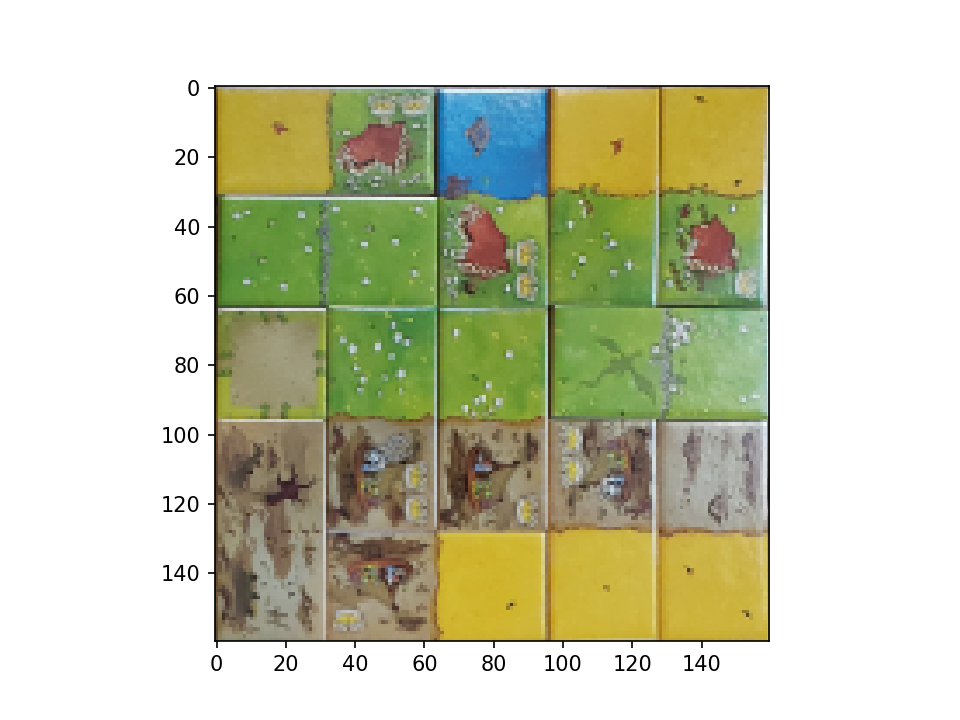

In [181]:
tile = fourPointExplodingHeartHomography(board, points_cropped, 32)
plt.figure()
plt.imshow(tile["image"])

In [170]:
# This setup follows 
# http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf

tile_res = 32

cx = [ p[0] for p in points_cropped ]
cy = [ p[1] for p in points_cropped ]
ix = [ 0, 5*tile_res, 5*tile_res, 0 ]
iy = [ 0, 0, 5*tile_res, 5*tile_res ]

# the following setups mapping of rhombus identified above to a rectangle with corners (0,0) and (2,1)
T1 = np.array([
    [cx[0], cy[0], 1.,     0,     0,  0, -cx[0]*ix[0], -cy[0]*ix[0]],
    [    0,     0,  0, cx[0], cy[0],  1, -cx[0]*iy[0], -cy[0]*iy[0]],
    [cx[1], cy[1], 1.,     0,     0,  0, -cx[1]*ix[1], -cy[1]*ix[1]],
    [    0,     0,  0, cx[1], cy[1],  1, -cx[1]*iy[1], -cy[1]*iy[1]],
    [cx[2], cy[2], 1.,     0,     0,  0, -cx[2]*ix[2], -cy[2]*ix[2]],
    [    0,     0,  0, cx[2], cy[2],  1, -cx[2]*iy[2], -cy[2]*iy[2]],
    [cx[3], cy[3], 1.,     0,     0,  0, -cx[3]*ix[3], -cy[3]*ix[3]],
    [    0,     0,  0, cx[3], cy[3],  1, -cx[3]*iy[3], -cy[3]*iy[3]]])

c1 = np.array([ix[0], iy[0], ix[1], iy[1], ix[2], iy[2], ix[3], iy[3]])

est = np.linalg.solve(T1, c1)
A = np.array([
    [est[0], est[1], est[2]],
    [est[3], est[4], est[5]],
    [est[6], est[7], 1.0]])
Ainv = np.linalg.inv(A)


print(est)
print(A)
print(Ainv)

[-3.92700737e-02 -1.94048454e-01  3.05777682e+02  2.67813464e-01
  9.65608434e-02 -1.53529048e+02  3.59829795e-04  4.85504879e-04]
[[-3.92700737e-02 -1.94048454e-01  3.05777682e+02]
 [ 2.67813464e-01  9.65608434e-02 -1.53529048e+02]
 [ 3.59829795e-04  4.85504879e-04  1.00000000e+00]]
[[ 2.01047987e+00  4.02454500e+00  3.12468876e+00]
 [-3.79603385e+00 -1.75429987e+00  8.91406440e+02]
 [ 1.11956239e-03 -5.96430056e-04  5.66093469e-01]]


In [173]:
c1

array([  0,   0, 160,   0, 160, 160,   0, 160])

In [66]:
# Maps origin onto target?
def regMap(xs, ys):
    txs = A[0, 0]*xs + A[0, 1]*ys + A[0, 2]
    tys = A[1, 0]*xs + A[1, 1]*ys + A[1, 2]
    hs = A[2, 0]*xs + A[2, 1]*ys + A[2, 2]
    txs = txs / hs
    tys = tys / hs
    return txs, tys

# Maps target onto origin
def invMap(xs, ys):
    txs = Ainv[0, 0]*xs + Ainv[0, 1]*ys + Ainv[0, 2]
    tys = Ainv[1, 0]*xs + Ainv[1, 1]*ys + Ainv[1, 2]
    hs = Ainv[2, 0]*xs + Ainv[2, 1]*ys + Ainv[2, 2]
    txs = txs / hs
    tys = tys / hs
    return txs, tys

(array([505.12374298, 507.46726506, 514.49218176, 512.15917764]), array([912.55226322, 904.73865465, 902.7666994 , 910.58429675]))


<IPython.core.display.Javascript object>


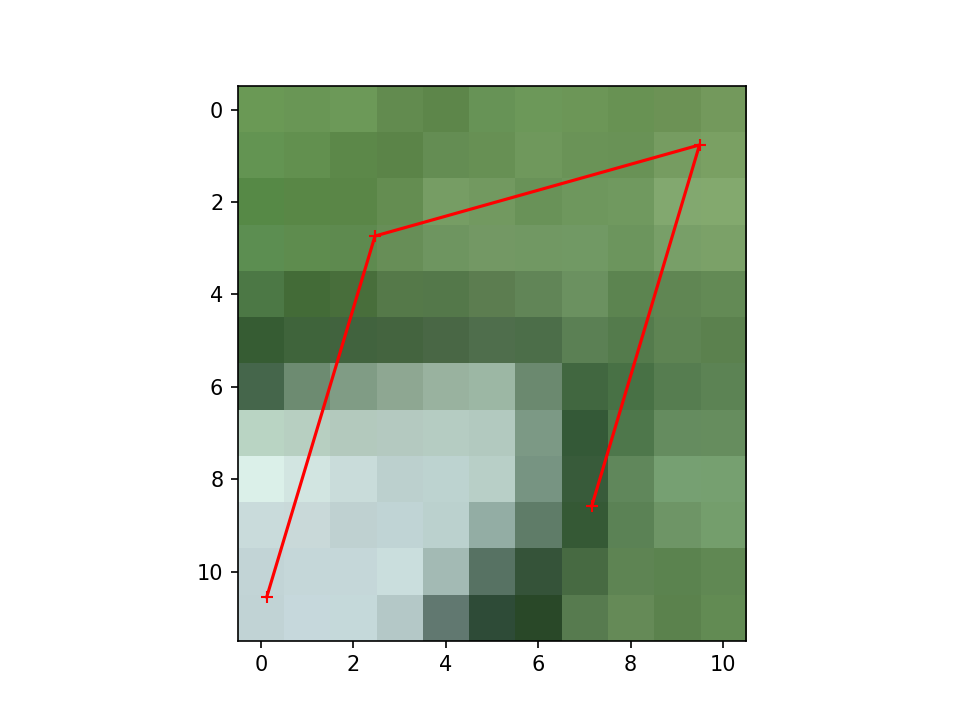

In [15]:
# Each pixel in our target grid maps back to some kind of quad
#  on the source image.  I want to figure out a way to quickly
#  take an average of the pixels in the source image 
def Helper(px, py):
    test = invMap(np.array([px, px+1, px+1, px]), np.array([py, py, py+1, py+1]))
    print(test)
    ex = (int(np.min(test[0])), int(1+np.max(test[0])))
    ey = (int(np.min(test[1])), int(1+np.max(test[1])))
    testx = [ x - ex[0] for x in test[0] ]
    testy = [ y - ey[0] for y in test[1] ]
    #print((ex, ey, testx, testy))
    plt.imshow(board[ey[0]:(ey[1]+1), ex[0]:(ex[1]+1)])
    plt.plot(testx, testy, 'r-+')
    
Helper(67, 43)

In [102]:
R = tile_res*5
result = np.zeros((R,R,3), 'int64')
counts = np.zeros((R,R,3), 'int32')

old_grid_y, old_grid_x = np.mgrid[0:board.shape[0], 0:board.shape[1]]
target_xs, target_ys = regMap(old_grid_x, old_grid_y)
txs = target_xs.astype('int32')
tys = target_ys.astype('int32')

for y in range(board.shape[0]):
    for x in range(board.shape[1]):
        rx = txs[y, x]
        ry = tys[y, x]
        if rx < 0 or ry < 0 or rx >= R or ry >= R: continue
        result[ry, rx] += board[y, x]
        counts[ry, rx] += 1


In [105]:
tys.shape

(1579, 1495)

<IPython.core.display.Javascript object>


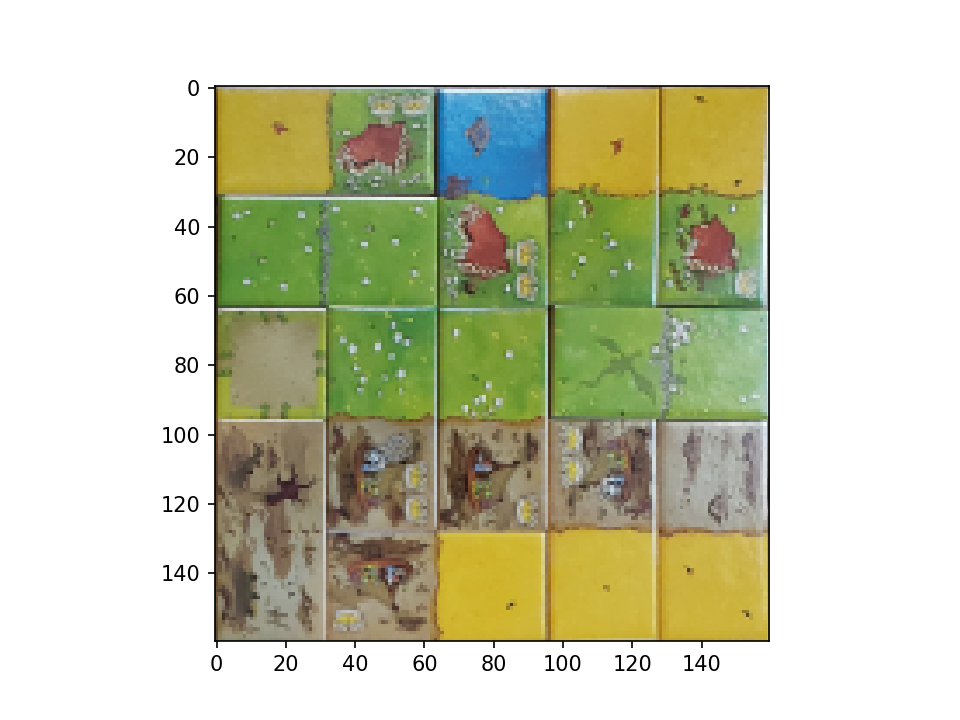

In [88]:
result2 = result / counts
plt.figure()
plt.imshow(result2.astype('int'))

In [147]:
result3 = np.zeros((R,R,3), 'int64')
mask = np.logical_and(np.logical_and(tys >= 0, tys < R), np.logical_and(txs >= 0, txs < R))
test = np.array([tys[mask], txs[mask], old_grid_y[mask], old_grid_x[mask]])
result3[ tys[mask], txs[mask] ] += board[ old_grid_y[mask], old_grid_x[mask] ]

In [148]:
?np.add.at

In [156]:
result3 = np.zeros((R,R,3), 'int64')
counts2 = np.zeros((R,R,3), 'int32')

np.add.at(result3, (tys[mask], txs[mask]), board[ old_grid_y[mask], old_grid_x[mask] ] )
np.add.at(counts2, (tys[mask], txs[mask]), 1 )

<IPython.core.display.Javascript object>


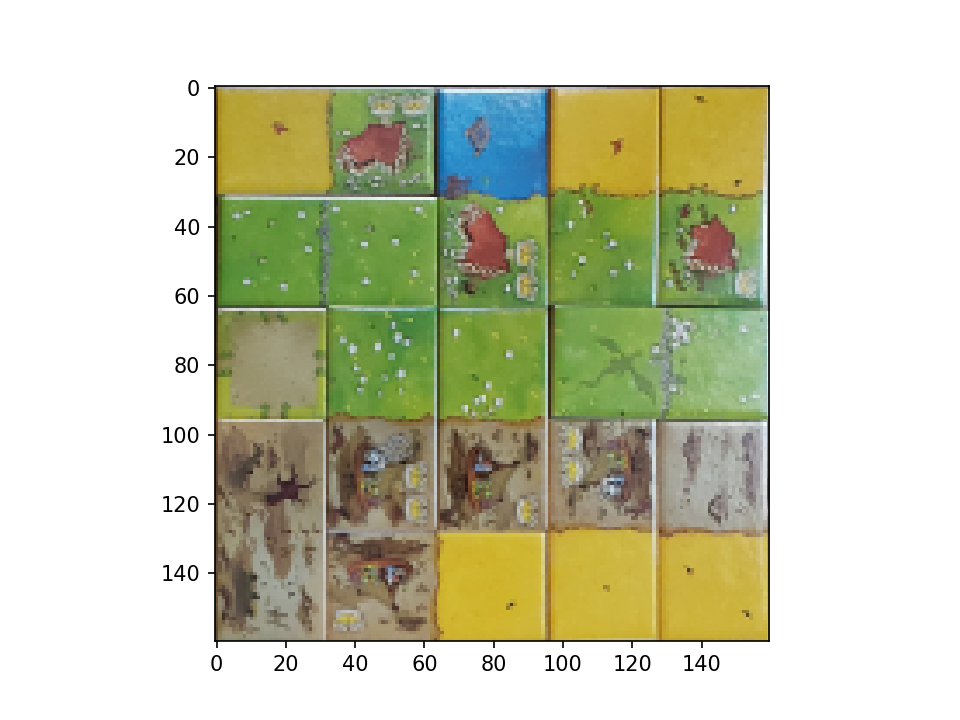

In [157]:
result4 = result3 / counts2
plt.figure()
plt.imshow(result4.astype('int'))

In [158]:
np.mean(result4 - result2)

0.0

<IPython.core.display.Javascript object>


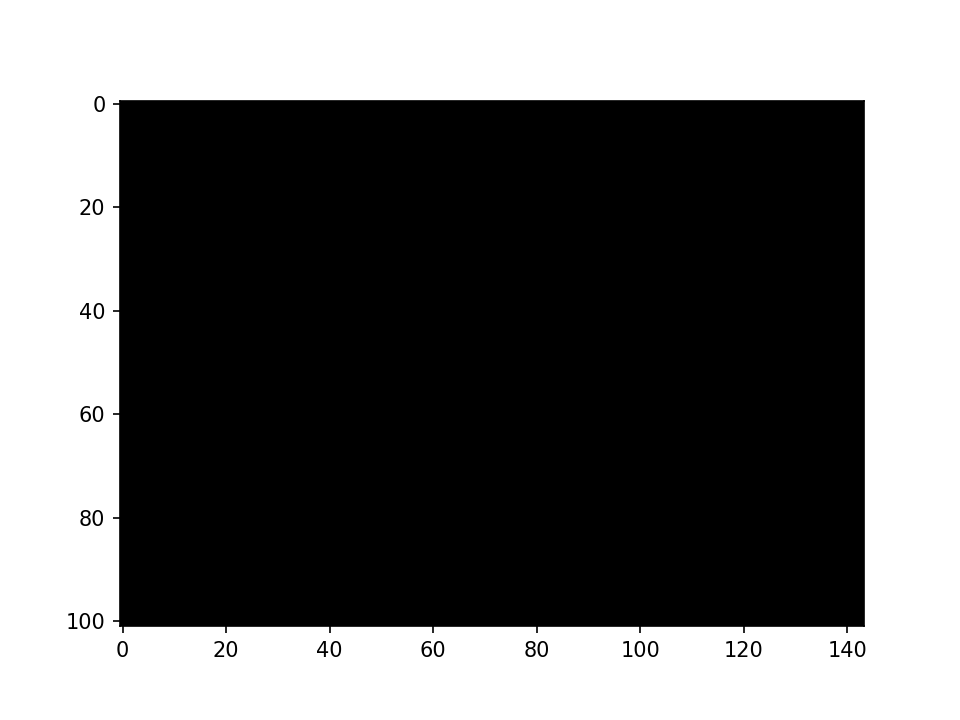

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [62]:
result = np.zeros((5*tile_res, 5*tile_res, 3), 'int32')
mask = np.zeros(board.shape)
ctr = 0
for px in range(5*tile_res):
    for pj in range(5*tile_res):
        ctr = ctr + 1
        test = invMap(np.array([px, px+1, px+1, px]), np.array([py, py, py+1, py+1]))
        test2
        = np.array([[x,y] for x, y in zip(test[0], test[1])]).reshape((-1, 1, 2)).astype('int32')        
        mask = cv2.fillConvexPoly(mask, test2, (px, pj, 0))
        
        #result[py, px] = (np.sum(board*mask, axis=(0,1)) / np.sum(mask, axis=(0,1))).astype('int')
        if ctr > 10: break
    if ctr > 10: break   
plt.imshow(mask)

In [65]:
mask[mask != 0]

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10.])

In [43]:
np.where(mask != 0)

(array([1563, 1563, 1563, 1564, 1564, 1564, 1573, 1573, 1573, 1574, 1574,
        1574]),
 array([16, 16, 16,  9,  9,  9, 12, 12, 12,  5,  5,  5]),
 array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [45]:
?cv2.polylines

In [ ]:
ys, xs = np.mgrid[0:(5*tile_res), 0:(5*tile_res)]
txs, tys = invMap(xs, ys)
old_grid_y, old_grid_x = np.mgrid[0:board.shape[0], 0:board.shape[1]]

In [ ]:
result = np.zeros((5*tile_res, 5*tile_res, 3))

for c in range(3):
    test = griddata(
        np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2),
        board[:,:,c].T.flatten(),
        (txs, tys))
    result[:,:,c] = test

In [ ]:
plt.imshow(result.astype('uint8'))

In [ ]:
plt.imshow(result[100:200, 100:200].astype('int'))

In [ ]:
np.histogram(result[100:200, 100:200].astype('int'))

In [ ]:
plt.imshow(board)

In [ ]:
result.shape

In [ ]:
cv2.imwrite("test.png", result)